In [1]:
import re
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
raw = pd.read_csv('train.csv')

In [3]:
# creating a function to clean the dataset
def cleaning(tweet):
    # creating pattern to remove url link
    pattern = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
    rem_link = re.sub(pattern, '', tweet)  # removing all links
    rem_punt = re.sub(r'[^a-zA-Z ]', '', rem_link)  # removing all character apart from symbols
    rem_punt = re.sub(r'RT', '', rem_punt)  # removing a specific word 'RT'
    conv_lower = rem_punt.lower().split()  # converting to lowercase and splitting
    stops = set(stopwords.words("english"))  # converting stopwords to 'set' for faster processing
    without_stop_sent = ' '.join([t for t in conv_lower if t not in stops])  # removing all stopwords from each tweet
    return without_stop_sent  # returning the final cleaned tweet


# applying the function to 'message' in the dataset
raw['cleaned_tweet'] = raw.message.apply(cleaning)


def hash_tag(tweet):
    result = ' '.join(re.findall(r'#\w+', tweet))
    return result


# applying the function to 'message' in the dataset
raw['hash_tag'] = raw.message.apply(hash_tag)

In [4]:
raw.sample(10)

,sentiment,message,tweetid,cleaned_tweet,hash_tag
6600,1,"So many people posting about standing rock, al...",360263,many people posting standing rock altright amp...,
9481,-1,RT @AbnInfVet: Man-made global warming is stil...,532585,abninfvet manmade global warming still myth ev...,
15473,1,RT @Fusion: America is about to become the onl...,208760,fusion america become country world leader doe...,
6545,2,"RT @mashable: In Trump's America, climate chan...",988739,mashable trumps america climate change researc...,
664,2,Trump to roll back use of climate change in po...,54145,trump roll back use climate change policy revi...,
3450,0,RT @pwwingman: Has Fizza got permission from G...,144317,pwwingman fizza got permission george ratifyau...,
10941,1,RT @1followernodad: parent: I'd do anything fo...,35380,followernodad parent id anything childrenscien...,
3459,1,"RT @damienics: Joint OBOR states, reads like a...",272240,damienics joint obor states reads like manifes...,
7664,2,RT @nytimes: President Trump may find some all...,866812,nytimes president trump may find allies climat...,
5333,1,RT @newsthump: NEWS! Theresa May appeases DUP’...,309958,newsthump news theresa may appeases dups clima...,


In [5]:
raw.to_csv('streamlit_preprocessed.csv', index=False)

In [6]:
words = raw.loc[15334, 'hash_tag']
words

'#Syria #Truth'

In [8]:
raw = pd.read_csv('streamlit_preprocessed.csv', keep_default_na=False)

In [9]:
raw

,sentiment,message,tweetid,cleaned_tweet,hash_tag
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesnt think carbon dio...,
1,1,It's not like we lack evidence of anthropogeni...,126103,like lack evidence anthropogenic global warming,
2,2,RT @RawStory: Researchers say we have three ye...,698562,rawstory researchers say three years act clima...,
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,todayinmaker wired pivotal year war climate ch...,#TodayinMaker
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,soynoviodetodas racist sexist climate change d...,#ElectionNight
...,...,...,...,...,...
15814,1,RT @ezlusztig: They took down the material on ...,22001,ezlusztig took material global warming lgbt ri...,
15815,2,RT @washingtonpost: How climate change could b...,17856,washingtonpost climate change could breaking m...,
15816,0,notiven: RT: nytimesworld :What does Trump act...,384248,notiven nytimesworld trump actually believe cl...,
15817,-1,RT @sara8smiles: Hey liberals the climate chan...,819732,sarasmiles hey liberals climate change crap ho...,#Agenda2030


In [10]:
def bag_of_words_count(words, word_dict={}):
    """ this function takes in a list of words and returns a dictionary
        with each word as a key, and the value represents the number of
        times that word appeared"""
    words = words.split()
    for word in words:
        if word in word_dict.keys():
            word_dict[word] += 1
        else:
            word_dict[word] = 1
    return word_dict


type_labels = raw.sentiment.unique()
personality = {}
df = raw.groupby('sentiment')
for pp in type_labels:
    personality[pp] = {}
    for row in df.get_group(pp)['hash_tag']:
        personality[pp] = bag_of_words_count(row, personality[pp])

count = 0
sentiment_cat = -1
iter_hash_num = 5
for w in sorted(personality[sentiment_cat], key=personality[sentiment_cat].get, reverse=True):
    count += 1
    print(w, personality[sentiment_cat][w])
    if count >= iter_hash_num:
        break

group_word_num = 7
# converting each word in the dataset into features
vectorizer = CountVectorizer(analyzer="word", ngram_range=(group_word_num, group_word_num),
                             max_features=50)  # setting the maximum feature to 8000
reviews_vect = vectorizer.fit_transform(df.get_group(sentiment_cat)['cleaned_tweet'])
features = reviews_vect.toarray()
# Knowing the features that are present
vocab = vectorizer.get_feature_names_out()
# Sum up the counts of each vocabulary word
dist = np.sum(features, axis=0)

# For each, print the vocabulary word and the number of times it
# appears in the training set
ngram_dict = {}
for tag, count in zip(vocab, dist):
    ngram_dict[tag] = count

most_pop = iter(sorted(ngram_dict, key=ngram_dict.get, reverse=True))

ngram_iter_num = 3
for x in range(ngram_iter_num):
    most_pop_iter = next(most_pop)
    print(most_pop_iter, ngram_dict[most_pop_iter])


#MAGA 11
#climate 10
#Trump 7
#climatechange 6
#OpChemtrails 4
concept global warming created chinese order make 24
global warming created chinese order make us 24
warming created chinese order make us manufacturing 24


In [11]:
def bag_of_words_count(words, word_dict={}):
    """ this function takes in a list of words and returns a dictionary
        with each word as a key, and the value represents the number of
        times that word appeared"""
    words = words.split()
    for word in words:
        if word in word_dict.keys():
            word_dict[word] += 1
        else:
            word_dict[word] = 1
    return word_dict


def hash_tag(sentiment_cat=1, iter_hash_num=5, labels=type_labels, dataframe=df):
    sentiment_dict = {}
    counter = 0
    for pp in labels:
        sentiment_dict[pp] = {}
        for row in dataframe.get_group(pp)['hash_tag']:
            sentiment_dict[pp] = bag_of_words_count(row, sentiment_dict[pp])
    result = {}
    for w in sorted(sentiment_dict[sentiment_cat], key=sentiment_dict[sentiment_cat].get, reverse=True):
        counter += 1
        result[w] = sentiment_dict[sentiment_cat][w]
        # print(w, sentiment_dict[sentiment_cat][w])
        if counter >= iter_hash_num:
            break
    return result

In [74]:
result = hash_tag()
result_df = pd.DataFrame.from_records([result])

In [53]:
result_df = result_df.T

In [57]:
result_df[[0]]

,0
#climate,187
#BeforeTheFlood,129
#climatechange,94
#ImVotingBecause,62
#COP22,59


In [67]:
import plotly.figure_factory as ff
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:>

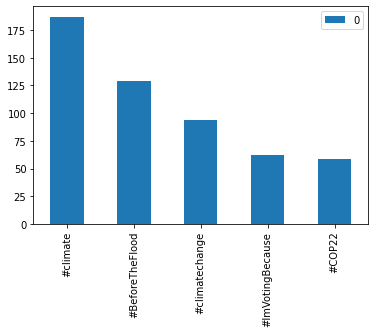

In [65]:
result_df.plot(kind='bar')

In [69]:
px.bar(result_df)

In [77]:
source = pd.DataFrame({
    'Frequency': result.values(),
    'Hash-Tag': result.keys()
})

In [80]:
source

,Frequency,Hash-Tag
0,187,#climate
1,129,#BeforeTheFlood
2,94,#climatechange
3,62,#ImVotingBecause
4,59,#COP22


<AxesSubplot:xlabel='Hash-Tag', ylabel='Frequency'>

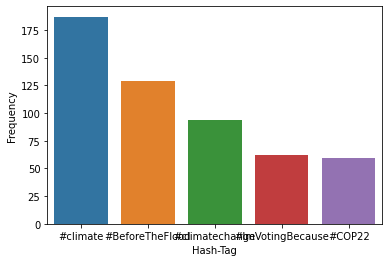

In [82]:
sns.barplot(data=source, y='Frequency', x='Hash-Tag')

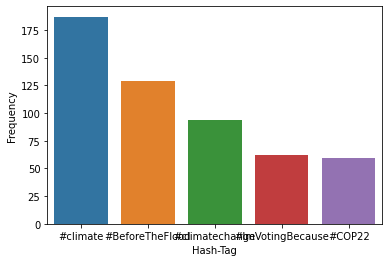

In [84]:
fig1 = sns.barplot(data=source, y='Frequency', x='Hash-Tag')
plt.show()

In [85]:
pip install wordcloud 

  Using cached wordcloud-1.8.1.tar.gz (220 kB)
Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: kiwisolver>=1.0.1 in c:\programdata\anaconda3\lib\site-packages (from matplotlib->wordcloud) (1.3.1)
  Running setup.py clean for wordcloud
Failed to build wordcloud
    Running setup.py install for wordcloud: started
    Running setup.py install for wordcloud: finished with status 'error'



  ERROR: Command errored out with exit status 1:
   command: 'C:\ProgramData\Anaconda3\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\Adetunji Emmanuel\\AppData\\Local\\Temp\\pip-install-qbo6td8j\\wordcloud_9ebb054dda0e4635876a2d6ae79b670f\\setup.py'"'"'; __file__='"'"'C:\\Users\\Adetunji Emmanuel\\AppData\\Local\\Temp\\pip-install-qbo6td8j\\wordcloud_9ebb054dda0e4635876a2d6ae79b670f\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\Adetunji Emmanuel\AppData\Local\Temp\pip-wheel-makqy8z4'
       cwd: C:\Users\Adetunji Emmanuel\AppData\Local\Temp\pip-install-qbo6td8j\wordcloud_9ebb054dda0e4635876a2d6ae79b670f\
  Complete output (20 lines):
  running bdist_wheel
  running build
  running build_py
  c